**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [2]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv30M = HFDataView()
dv1H = HFDataView()
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))
Gap30= dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

Initialize dataview success.
Initialize dataview success.


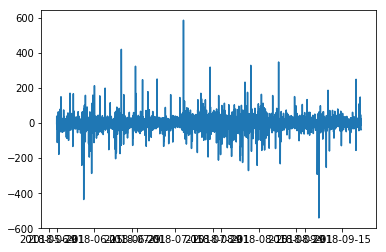

In [5]:
#30min图
import matplotlib.pyplot as plt
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

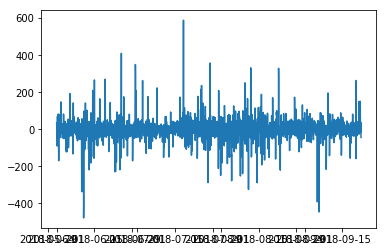

In [6]:
#1H的图
import matplotlib.pyplot as plt
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [32]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

Field [alpha10_C] is overwritten.
Field [alpha10_C] is overwritten.


In [37]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()
    
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

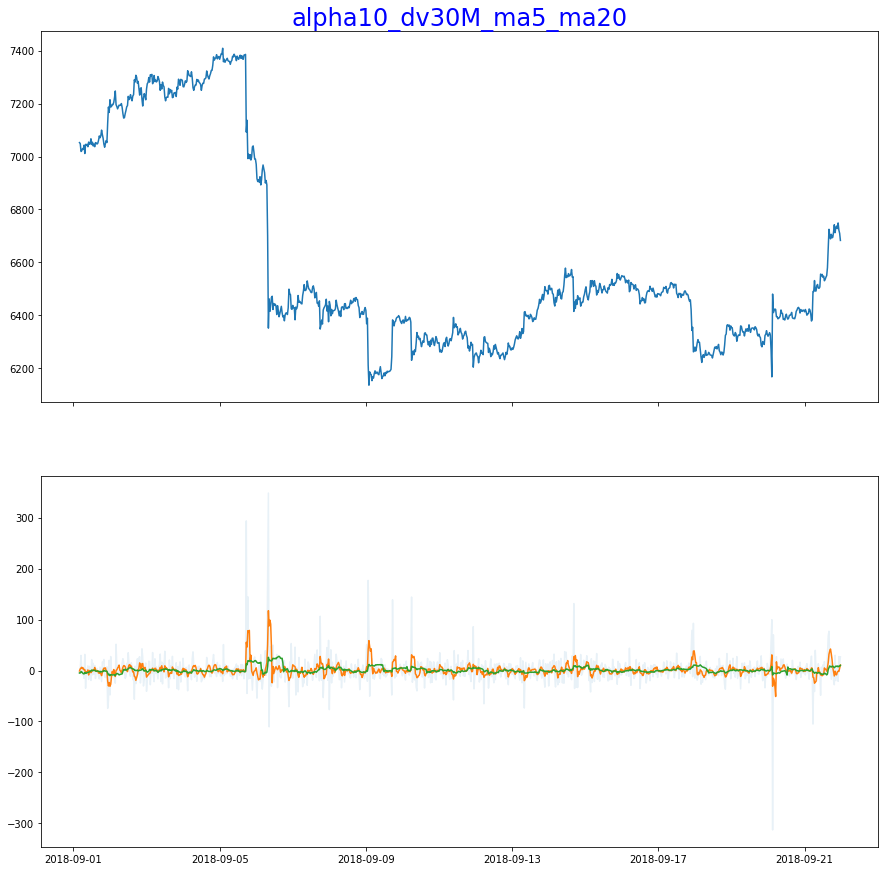

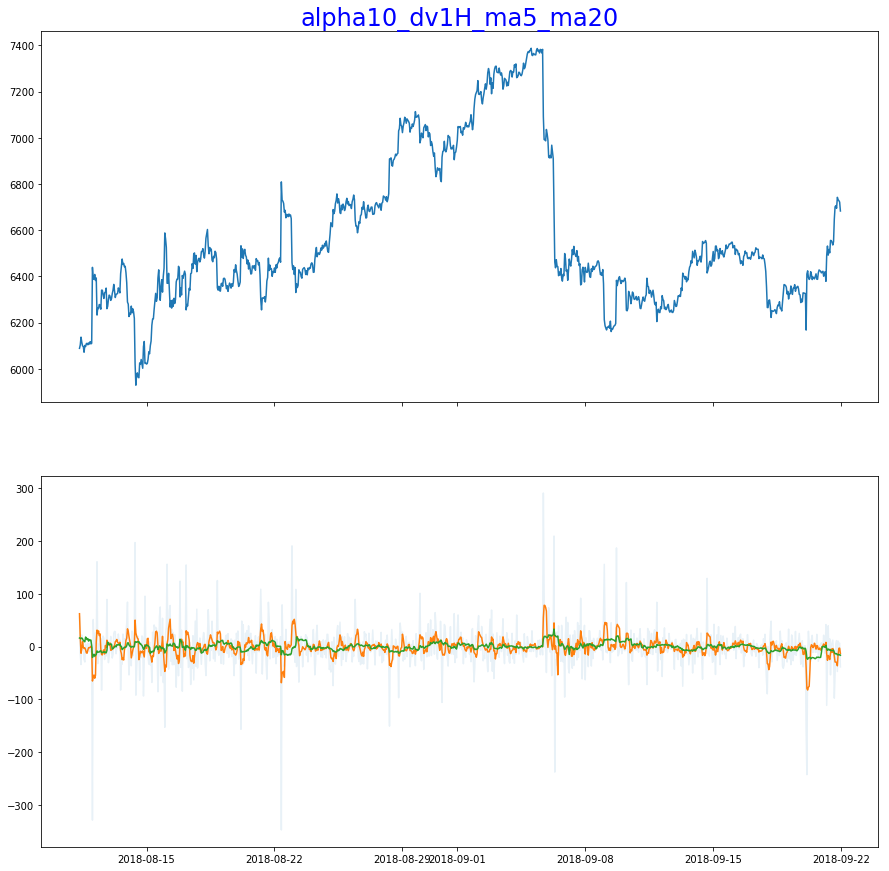

In [38]:
import pandas as pd
#alpha1_dv30M是30分钟线，1H是1小时线，ma5和ma20代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [40]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)


Field [longAlpha10] is overwritten.
Field [shortAlpha10] is overwritten.
Field [closeLongAlpha10] is overwritten.
Field [closeShortAlpha10] is overwritten.


In [42]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [43]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')

def TimingSignal(td, dv, long='longAlpha10', short='shortAlpha10',closeLong='closeLongAlpha10', closeShort='closeShortAlpha10'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

C:\Users\979076458\AppData\Local\conda\conda\envs\py36\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


In [45]:
TimingSignal(tdAlpha10, dv1H, long='longAlpha10', short='shortAlpha10',closeLong='closeLongAlpha10', closeShort='closeShortAlpha10', mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [46]:
#(sig_type="long_short")
tdAlpha10.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [70]:
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

In [71]:
data1H = Time_dict.set_index('datetime')

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [72]:
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [76]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [77]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [78]:
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100

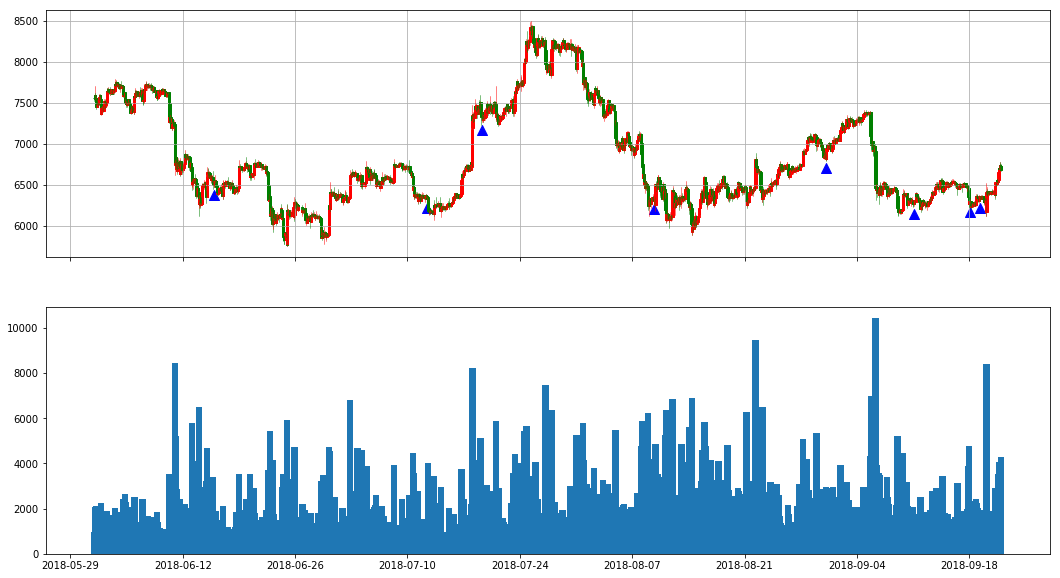

In [74]:
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields':'open,high,low,close,volume',
         'freq':'1H',
         'symbol':'BTCUSDT:binance',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [3]:
#因子：MACD
dv1H.add_formula('MACD', "Ta('EMA',0,0,0,0,close,0,12) - Ta('EMA',0,0,0,0,close,0,26)", add_data = True)
dv1H.add_formula('MACD_Signal', "Ta('EMA',0,0,0,0,MACD,9)", add_data = True)
dv1H.add_formula('Hist', "2*(MACD-MACD_Signal)", add_data = True)

symbol,BTCUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,NaN


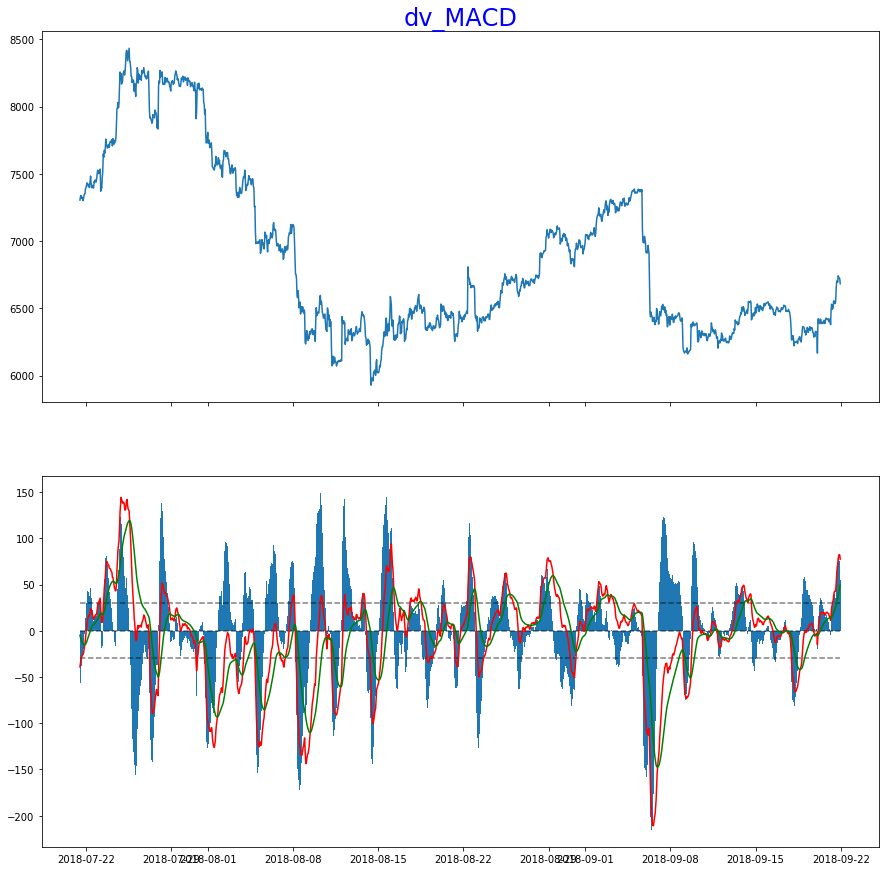

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def Plot_MACD(dv, MACD, MACD_Signal, Hist, chart_name='dv_MACD', n=-1500):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(MACD.iloc[n:], color = 'r')
    ax1.plot(MACD_Signal.iloc[n:], color = 'g')
    ax1.hlines(0, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    ax1.hlines(30, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    ax1.hlines(-30, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    ax1.bar(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:].index ,Hist.iloc[n:],width = 0.05)
    plt.show()
    
MACD = dv1H.get_ts('MACD',date_type = 'datetime')
MACD_Signal = dv1H.get_ts('MACD_Signal',date_type = 'datetime')
Hist = dv1H.get_ts('Hist',date_type = 'datetime')
Plot_MACD(dv1H, MACD.iloc[:,0], MACD_Signal.iloc[:,0], Hist.iloc[:,0])

In [ ]:
研究报告
因子：动能指标MACD MACD = 12'day'EMA-26'day'EMA MACD'signal = 9'day'EMA(MACD) Hist = MACD-MACD'signal
红线：MACD 绿线：MACD_signal 柱状图：Hist
现象： （1）红线绿线的趋势相对于柱状图的趋势有一定的滞后性 （2）红线下叉绿线时，柱状图由正变负 ；红线上叉绿线时，柱状图由负变正

In [5]:
#RSI因子
dv1H.add_formula('RSI6', "Ta('RSI',0,0,0,0,close,0,6)", add_data = True)
dv1H.add_formula('RSI24', "Ta('RSI',0,0,0,0,close,0,24)", add_data = True)

symbol,BTCUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,NaN


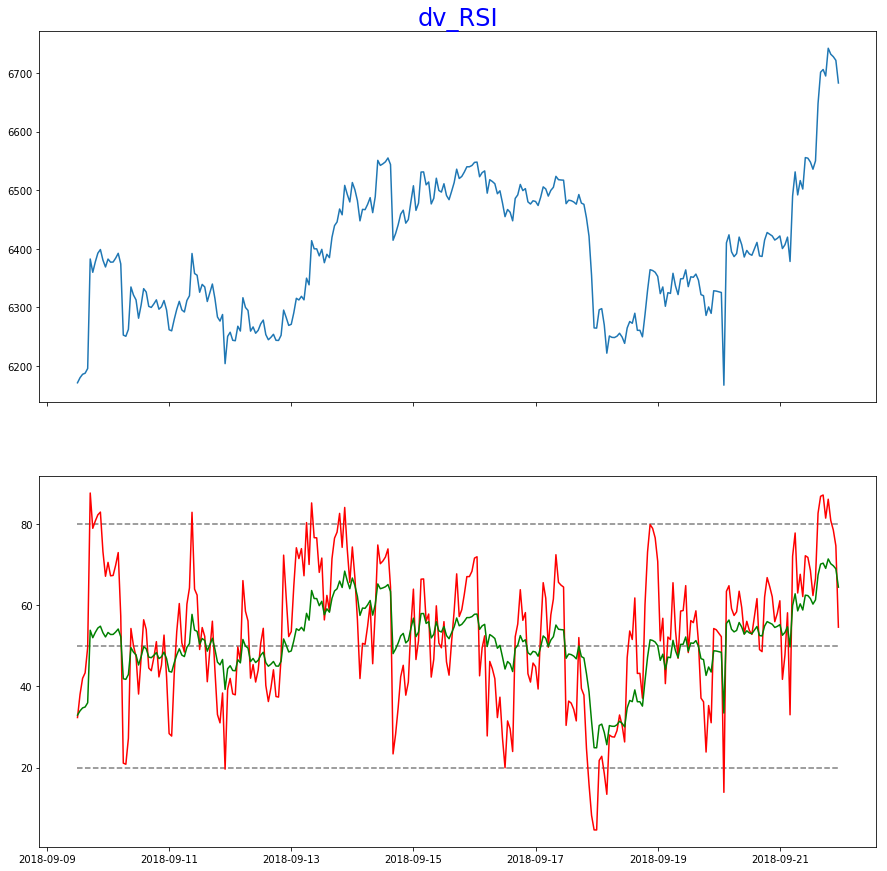

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def Plot_RSI(dv, RSI_short, RSI_long, chart_name='dv_RSI', n=-300):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(RSI_short.iloc[n:], color = 'r')
    ax1.plot(RSI_long.iloc[n:], color = 'g')
    ax1.hlines(80, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    ax1.hlines(20, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    ax1.hlines(50, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.5, linestyle='--')
    plt.show()
    
RSI_short = dv1H.get_ts('RSI6',date_type = 'datetime')
RSI_long = dv1H.get_ts('RSI24',date_type = 'datetime')
Plot_RSI(dv1H, RSI_short.iloc[:,0], RSI_long.iloc[:,0])

In [ ]:
研究报告
因子：双线动能指标RSI（N取6和24） RSI = SMA(MAX(Close-LastClose,0),N,1)/SMA(ABS(Close-LastClose),N,1)*100
红线：RSI6 绿线：RSI24
现象： RSI值将市场分成"极弱"、"弱""强"到"极强"四个区域。"强"和"弱"以50作为分界线,"极弱"和"弱"之间以及"强"和"极强"之间的界限则要随着RSI参数N的变化而变化。不同的参数,其区域的划分就不同。参数越大,分界线离中心线50就越近,离100和0就越远。

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [ ]:
信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。
此处需要说出联系、找到的信号、你的信号进出场假设是什么

MACD研究报告
与价格图的联系： Hist由负变正，close由跌转涨。 Hist由正变负，close由涨转跌。 Hist的值为正时若出现向下趋势，上涨动能减小，下跌的可能性增大 Hist的值为负时若出现向上趋势，下跌动能减小，上涨的可能性增大 Hist柱线消失随时有可能出现涨跌转换 两条线数值位干0轴的下方时，说明目前的大势属干空头市场，应当以持币观望为主要策略
信号： (1)MACD与MACD_signal交叉信号 (2)MACD小于-30时，市场处于弱势；MACD大于30时，市场处于强势
进出场信号： 进场：在MACD线上叉MACD_signal且MACD大于-30时开多，下叉且MACD小于30时平多 出场：在MACD线下叉MACD_signal且MACD小于30时开空，上叉且MACD大于-30时平空

RSI研究报告
与价格图的联系： 当RSI6线在低位(小于40)向上突破RSI24线，close上涨 当RSI6线在高位(大于60)向下突破RSI24线，close下跌 当RSI6大于80时为超买，close将有下跌趋势 当RSI6小于20时为超卖，close将有上涨趋势
信号： （1）RSI6与RSI24的交叉信号 （2）RSI6的超卖超买信号
进出场信号： 进场：RSI6小于40时，RSI6线上叉RSI24线 或 RSI6向下穿过20时开多，RSI6大于60下叉 或RSI6向上穿过80时平多 出场：RSI6大于60时，RSI6线下叉RSI24线 或 RSI6向上穿过80时开空，RSI6小于40上叉 或RSI6向下穿过20时平空

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
